# Algoritmos de clustering



# **Datos nutricionales del menú de Burger King**
Este conjunto de datos es una recopilación completa de información nutricional de los principales elementos del menú que ofrece Burger King. El conjunto de datos incluye información sobre la cantidad de calorías, grasas totales, grasas saturadas, grasas trans, colesterol, sodio, carbohidratos totales y proteínas que se encuentran en cada elemento del menú.

Esta información permite a las personas tomar decisiones informadas sobre su ingesta dietética y les ayuda a gestionar mejor su salud y bienestar.

https://www.kaggle.com/datasets/mattop/burger-king-menu-nutrition-data/data

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from dask_ml.cluster import KMeans
import dask.array as da
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Cargar datos
data = pd.read_csv('Datos_clustering/burger-king-menu.csv')



In [3]:
data.head()

,Item,Category,Calories,Fat Calories,Fat (g),Saturated Fat (g),Trans Fat (g),Cholesterol (mg),Sodium (mg),Total Carb (g),Dietary Fiber (g),Sugars (g),Protein (g),Weight Watchers
0,Whopper® Sandwich,Burgers,660.0,360.0,40.0,12.0,1.5,90.0,980.0,49.0,2.0,11.0,28.0,655.0
1,Whopper® Sandwich with Cheese,Burgers,740.0,420.0,46.0,16.0,2.0,115.0,1340.0,50.0,2.0,11.0,32.0,735.0
2,Bacon & Cheese Whopper® Sandwich,Burgers,790.0,460.0,51.0,17.0,2.0,125.0,1560.0,50.0,2.0,11.0,35.0,783.0
3,Double Whopper® Sandwich,Burgers,900.0,520.0,58.0,20.0,3.0,175.0,1050.0,49.0,2.0,11.0,48.0,883.0
4,Double Whopper® Sandwich with Cheese,Burgers,980.0,580.0,64.0,24.0,3.0,195.0,1410.0,50.0,2.0,11.0,52.0,963.0


In [4]:
#Preprocesamiento
data.isnull().sum()

Item                 0
Category             0
Calories             0
Fat Calories         0
Fat (g)              0
Saturated Fat (g)    0
Trans Fat (g)        0
Cholesterol (mg)     0
Sodium (mg)          0
Total Carb (g)       0
Dietary Fiber (g)    0
Sugars (g)           0
Protein (g)          0
Weight Watchers      0
dtype: int64

In [5]:
data.describe()

,Calories,Fat Calories,Fat (g),Saturated Fat (g),Trans Fat (g),Cholesterol (mg),Sodium (mg),Total Carb (g),Dietary Fiber (g),Sugars (g),Protein (g),Weight Watchers
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,501.428571,278.311688,30.967532,9.805195,0.636364,101.753247,993.246753,35.181818,1.779221,6.636364,20.909091,497.064935
std,307.612685,184.393762,20.535966,8.118431,1.128682,97.958659,613.426403,20.716588,1.690713,6.973463,17.145033,302.238070
min,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,12.000000
25%,260.000000,140.000000,16.000000,3.500000,0.000000,25.000000,470.000000,26.000000,1.000000,1.000000,12.000000,252.000000
50%,430.000000,250.000000,28.000000,8.000000,0.000000,70.000000,1010.000000,30.000000,1.000000,6.000000,17.000000,416.000000
75%,700.000000,380.000000,42.000000,14.000000,0.500000,175.000000,1420.000000,49.000000,2.000000,10.000000,28.000000,690.000000
max,1220.000000,750.000000,84.000000,33.000000,4.500000,390.000000,2840.000000,110.000000,9.000000,40.000000,71.000000,1192.000000


In [6]:
data.columns

Index(['Item', 'Category', 'Calories', 'Fat Calories', 'Fat (g)',
       'Saturated Fat (g)', 'Trans Fat (g)', 'Cholesterol (mg)', 'Sodium (mg)',
       'Total Carb (g)', 'Dietary Fiber (g)', 'Sugars (g)', 'Protein (g)',
       'Weight Watchers'],
      dtype='object')

In [8]:
#Seleccione las columnas de Grasas totales y total de carbohidratos .
X =  data.iloc[:, [4, 9]].values
X[0:5]


array([[40., 49.],
       [46., 50.],
       [51., 50.],
       [58., 49.],
       [64., 50.]])

In [9]:
#Escalado de datos
X_s = StandardScaler()
X_std=X_s.fit_transform(X)
X_std[0:5]

array([[0.44272071, 0.67138438],
       [0.73680693, 0.71997141],
       [0.98187878, 0.71997141],
       [1.32497937, 0.67138438],
       [1.61906559, 0.71997141]])

In [10]:
#Convertir a Dask array
X_std_dask = da.from_array(X_std,chunks=(1000,2))

## **Algoritmo K-means**

In [36]:
#K-means con Dask-ML
kmeans = KMeans(n_clusters=5,init='k-means||',max_iter=300,n_init=10,random_state=0)
kmeans.fit(X_std_dask)

KMeans(n_clusters=5, n_init=10, random_state=0)

In [38]:
#Predicciones de los clusters
y_kmeans=kmeans.predict(X_std_dask).compute()
y_kmeans

array([2, 2, 2, 2, 0, 0, 0, 1, 0, 0, 2, 2, 2, 0, 2, 3, 3, 1, 1, 2, 1, 1,
       2, 2, 2, 2, 2, 1, 1, 3, 3, 1, 2, 3, 3, 1, 0, 3, 3, 2, 3, 3, 3, 3,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 4, 4, 2, 3, 2, 2, 3,
       1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [39]:
#Obtener los centroides estandarizados
centroides_estandarizados=kmeans.cluster_centers_

In [40]:
centroides_estandarizados

array([[ 2.16522572,  0.74079442],
       [-0.19020399, -0.24331922],
       [ 0.58042775,  0.85879148],
       [-1.01443567, -1.00689253],
       [ 0.68779256,  3.27079035]])

In [41]:
#Añadir la información de los clusters a los datos originales
data['cluster']=y_kmeans
data.head()

,Item,Category,Calories,Fat Calories,Fat (g),Saturated Fat (g),Trans Fat (g),Cholesterol (mg),Sodium (mg),Total Carb (g),Dietary Fiber (g),Sugars (g),Protein (g),Weight Watchers,cluster
0,Whopper® Sandwich,Burgers,660.0,360.0,40.0,12.0,1.5,90.0,980.0,49.0,2.0,11.0,28.0,655.0,2
1,Whopper® Sandwich with Cheese,Burgers,740.0,420.0,46.0,16.0,2.0,115.0,1340.0,50.0,2.0,11.0,32.0,735.0,2
2,Bacon & Cheese Whopper® Sandwich,Burgers,790.0,460.0,51.0,17.0,2.0,125.0,1560.0,50.0,2.0,11.0,35.0,783.0,2
3,Double Whopper® Sandwich,Burgers,900.0,520.0,58.0,20.0,3.0,175.0,1050.0,49.0,2.0,11.0,48.0,883.0,2
4,Double Whopper® Sandwich with Cheese,Burgers,980.0,580.0,64.0,24.0,3.0,195.0,1410.0,50.0,2.0,11.0,52.0,963.0,0


In [32]:
print(y_kmeans.shape)

(77,)


In [33]:
print(y_kmeans.dtype)

int32


In [47]:
# Transformación inversa de los centroides para obtener los valores originales
centroides_originales = X_s.inverse_transform(centroides_estandarizados)

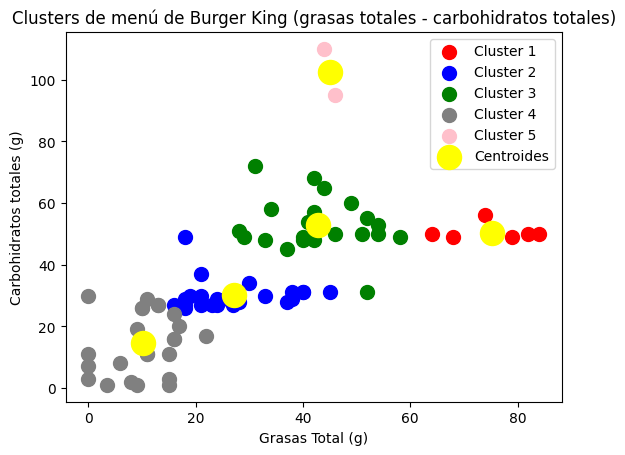

In [44]:
# Visualizando los clusters
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s=100, c='red', label='Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s=100, c='blue', label='Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s=100, c='green', label='Cluster 3')
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s=100, c='gray', label='Cluster 4')
plt.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], s=100, c='pink', label='Cluster 5')
# Traza el centroide
plt.scatter(centroides_originales[:, 0], centroides_originales[:, 1], s=300, c='yellow', label='Centroides')
plt.title('Clusters de menú de Burger King (grasas totales - carbohidratos totales)')
plt.xlabel('Grasas Total (g)')
plt.ylabel('Carbohidratos totales (g)')
plt.legend()
plt.show()

### **Métrica Silhouette Score**
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

Calcule el coeficiente de silueta medio de todas las muestras.

In [45]:
silhouette_score(X_std, y_kmeans)

0.42543368368174217

### **Métrica  Davies-Bouldin Index**

Es una métrica de validación que se utiliza para evaluar modelos de agrupación.

https://www.geeksforgeeks.org/davies-bouldin-index/

In [23]:
from sklearn.metrics import davies_bouldin_score
davies_bouldin_score(X_std, y_kmeans)

0.6861412675645467

In [25]:
pip install pyspark


  Using cached pyspark-3.5.1.tar.gz (317.0 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl.metadata (1.5 kB)
Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488531 sha256=a5516060d5d25e562343d563a798e14b3b232f03c97f04939ed562015bcf19a5
  Stored in directory: c:\users\asus\appdata\local\pip\cache\wheels\92\09\11\aa01d01a7f005fda8a66ad71d2be7f8aa341bddafb27eee3c7
Successfully built pyspark


In [ ]:
#Iniciar el servidor PySpark 
from pyspark.sql import SparkSession 
spark = SparkSession.builder.appName('cluster').getOrCreate() 
print('Spark Version: {}'.format(spark.version))

In [ ]:
from pyspark.sql import SparkSession

spark= SparkSession.builder.appName("example").getOrCreate()
# Leer el archivo CSV como un DataFrame
df = spark.read.csv('Datos_clustering/burger-king-menu.csv', header=True, inferSchema=True)

# Mostrar el esquema del DataFrame
df.printSchema()

# Seleccionar las columnas "Grasas totales" y "Total de carbohidratos"
selected_columns = df.select('Fat (g)', 'Total Carb (g)')

# Mostrar las primeras filas del DataFrame seleccionado
selected_columns.show(5)

# Detener la sesión de Spark
spark.stop()


In [241]:
from pyspark.sql import SparkSession

# Crear una sesión de Spark
spark = SparkSession.builder.appName("examplehola").getOrCreate()

# Leer un archivo CSV como un DataFrame
df = spark.read.csv('Datos_clustering/burger-king-menu.csv', header=True, inferSchema=True)

## **DBSCAN**

In [78]:
from sklearn.cluster import DBSCAN
import numpy as np
clustering = DBSCAN().fit(X_std)  # Ajusta el modelo DBSCAN a los datos representados en X_std
labels = clustering.labels_  # Obtiene las etiquetas asignadas a cada punto por el algoritmo DBSCAN

# Imprime las etiquetas de los clústeres asignadas a cada punto
print(labels)

[ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  1  1  1  1  0  1  1  0  0
  0  0  0  1  1  1  1  1  0  1  1  1  0  1  1  0  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1  1  0  0  1  0  1  1  1  1 -1
  1  1  1  1  1]


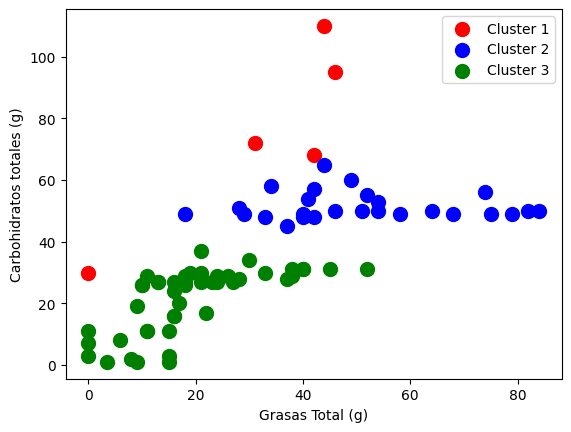

In [79]:
#Visualizando los clusters
plt.scatter(X[labels==-1, 0], X[labels==-1, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(X[labels==0, 0], X[labels==0, 1], s=100, c='blue', label ='Cluster 2')
plt.scatter(X[labels==1, 0], X[labels==1, 1], s=100, c='green', label ='Cluster 3')


#Traza el centroide. Esta vez vamos a utilizar los centros de cluster.
#atributo que devuelve aquí las coordenadas del centroide.
plt.legend()
plt.xlabel('Grasas Total (g)')
plt.ylabel('Carbohidratos totales (g)')
plt.show()

### **Métrica Silhouette Score**
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

Calcule el coeficiente de silueta medio de todas las muestras.

In [80]:
silhouette_score(X_std, labels)

0.4653539616416159

### **Métrica  Davies-Bouldin Index**

Es una métrica de validación que se utiliza para evaluar modelos de agrupación.

https://www.geeksforgeeks.org/davies-bouldin-index/

In [81]:
from sklearn.metrics import davies_bouldin_score
davies_bouldin_score(X_std, labels)

1.1864415000593997

## **Agglomerative Clustering**
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

In [215]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

# Se realiza el agrupamiento jerárquico con AgglomerativeClustering
clustering = AgglomerativeClustering().fit(X_std)  
# Ajusta el modelo de agrupamiento jerárquico a los datos representados en X_std

# Imprime el objeto clustering
print(clustering)

AgglomerativeClustering()

In [216]:
labels1=clustering.labels_
labels1

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

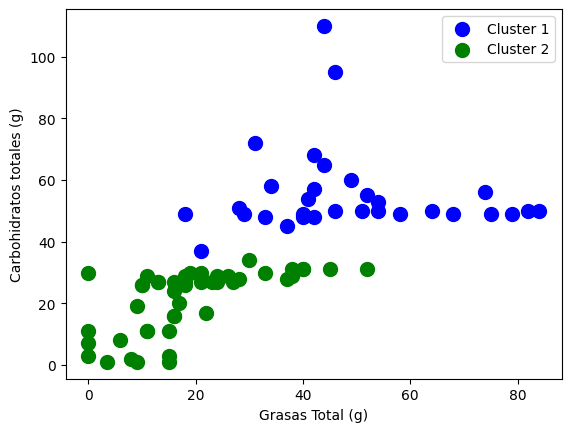

In [218]:
#Visualizando los clusters
plt.scatter(X[labels1==0, 0], X[labels1==0, 1], s=100, c='blue', label ='Cluster 1')
plt.scatter(X[labels1==1, 0], X[labels1==1, 1], s=100, c='green', label ='Cluster 2')


#Traza el centroide. Esta vez vamos a utilizar los centros de cluster.
#atributo que devuelve aquí las coordenadas del centroide.
plt.legend()
plt.xlabel('Grasas Total (g)')
plt.ylabel('Carbohidratos totales (g)')
plt.show()

### **Métrica Silhouette Score**
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

Calcule el coeficiente de silueta medio de todas las muestras.

In [219]:
silhouette_score(X_std, labels1)

0.5013492135531722

### **Métrica  Davies-Bouldin Index**

Es una métrica de validación que se utiliza para evaluar modelos de agrupación.

https://www.geeksforgeeks.org/davies-bouldin-index/

In [220]:
from sklearn.metrics import davies_bouldin_score
davies_bouldin_score(X_std, labels1)

0.7290251752161105